Introduction

The present analysis aims to evaluate the efficiency of public spending by executing entities during the year 2024. For this purpose, an indicator called Eficiencia_2024 was constructed, obtained from the relationship between the amount disbursed (GIRADO_2024) and the modified institutional budget (PIM_2024).

Based on this indicator, entities were classified into performance levels (Low, Medium, High, and Over-execution) and a Random Forest model was applied to identify the factors that influence this efficiency.

This approach not only measures the degree of budget execution but also helps to understand which variables have the greatest impact on the efficient management of public resources.

In [1]:
# ==========================================================
# 📘 ANALISIS ESTRUCTURAL COMPARATIVO DE GASTOS (NO TEMPORAL)
# ==========================================================
# Autor: David Gozar Neira
# Fecha: 2025
# Versión: 1.0
# ----------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap
import os

# ======================
# 1️⃣ Cargar y limpiar datos
# ======================
url = "https://github.com/DavidGN2016GFS/comparativo-gastos-peru-2012-2025/releases/download/v1.0.0/comparativo_gastos_2022_2025_40k_limpio.csv"
df = pd.read_csv(url)

c:\Users\user\tf_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import numpy as np
import pandas as pd

# 🔹 Suponiendo que tienes el DataFrame final escalado:
# (df_scaled o df_encoded, según tu paso anterior)
num_cols = df_scaled.select_dtypes(include=np.number).columns

# Calcular correlación solo de las columnas numéricas principales
corr_opt = df_scaled[num_cols].corr()

# Contar correlaciones > 0.65 sin duplicar ni diagonal
corr_mayores = corr_opt.where(np.triu(np.ones(corr_opt.shape), k=1).astype(bool))
conteo = (corr_mayores.abs() > 0.65).sum().sum()

print(f"🔹 Número total de correlaciones > 0.65: {conteo}")



🔹 Número total de correlaciones > 0.65: 92


In [4]:
import numpy as np

# Calcular la matriz de correlaciones (si aún no la tienes)
corr_opt = df.corr(numeric_only=True)

# Contar correlaciones mayores a 0.8 (sin duplicar ni incluir la diagonal)
corr_mayores = corr_opt.where(np.triu(np.ones(corr_opt.shape), k=1).astype(bool))
conteo_08 = (corr_mayores.abs() > 0.8).sum().sum()

print(f"🔹 Número total de correlaciones > 0.8: {conteo_08}")


🔹 Número total de correlaciones > 0.8: 33


In [5]:
altas = corr_opt.unstack().reset_index()
altas.columns = ['Var1', 'Var2', 'Correlacion']
altas = altas[(altas['Var1'] != altas['Var2']) & (altas['Correlacion'].abs() > 0.8)]
altas = altas.sort_values(by='Correlacion', ascending=False)
print(altas.head(10))


                   Var1               Var2  Correlacion
2235        GIRADO_2024     DEVENGADO_2024     1.000000
2185     DEVENGADO_2024        GIRADO_2024     1.000000
1457     DEVENGADO_2022        GIRADO_2022     0.999973
1507        GIRADO_2022     DEVENGADO_2022     0.999973
2183     DEVENGADO_2024  COMPROMETIDO_2024     0.999943
2133  COMPROMETIDO_2024     DEVENGADO_2024     0.999943
2134  COMPROMETIDO_2024        GIRADO_2024     0.999943
2234        GIRADO_2024  COMPROMETIDO_2024     0.999943
1769  COMPROMETIDO_2023     DEVENGADO_2023     0.999935
1819     DEVENGADO_2023  COMPROMETIDO_2023     0.999935


In [12]:
import pandas as pd
import numpy as np

# Si ya tienes tu DataFrame principal (por ejemplo df_scaled), úsalo:
# Si no estás seguro, puedes usar df en lugar de df_scaled.
try:
    base_corr = df_scaled  # intenta usar el DataFrame escalado
except NameError:
    base_corr = df  # si df_scaled no existe, usa df

# Seleccionar solo columnas numéricas
num_cols = base_corr.select_dtypes(include=np.number).columns
corr_opt = base_corr[num_cols].corr()

# Crear matriz triangular superior (sin duplicados ni diagonal)
corr_mayores = corr_opt.where(np.triu(np.ones(corr_opt.shape), k=1).astype(bool))

# Convertir a formato largo
corr_altas = corr_mayores.stack().reset_index()
corr_altas.columns = ['Var1', 'Var2', 'Correlacion']

# Filtrar correlaciones mayores a 0.8
corr_altas = corr_altas[corr_altas['Correlacion'].abs() > 0.8].sort_values(by='Correlacion', ascending=False)

print(f"🔹 Total correlaciones > 0.8: {corr_altas.shape[0]}")
display(corr_altas.head(10))


🔹 Total correlaciones > 0.8: 33


,Var1,Var2,Correlacion
1239,DEVENGADO_2024,GIRADO_2024,1.000000
1022,DEVENGADO_2022,GIRADO_2022,0.999973
1230,COMPROMETIDO_2024,DEVENGADO_2024,0.999943
1231,COMPROMETIDO_2024,GIRADO_2024,0.999943
1139,COMPROMETIDO_2023,DEVENGADO_2023,0.999935
1209,CERTIFICADO_2024,COMPROMETIDO_ANUAL_2024,0.998268
1274,DEVENGADO_2025,GIRADO_2025,0.997167
1104,CERTIFICADO_2023,COMPROMETIDO_ANUAL_2023,0.995269
924,PIM_2022,CERTIFICADO_2022,0.991592
1197,PIM_2024,CERTIFICADO_2024,0.990148


In [13]:
import pandas as pd
import numpy as np

# Intentar usar df_scaled si existe, si no usar df
try:
    base_corr = df_scaled
except NameError:
    base_corr = df

# Seleccionar solo columnas numéricas
num_cols = base_corr.select_dtypes(include=np.number).columns
corr_opt = base_corr[num_cols].corr()

# Crear matriz triangular superior (sin duplicados ni diagonal)
corr_mayores = corr_opt.where(np.triu(np.ones(corr_opt.shape), k=1).astype(bool))

# Convertir a formato largo
corr_altas = corr_mayores.stack().reset_index()
corr_altas.columns = ['Var1', 'Var2', 'Correlacion']

# 🔹 Filtrar correlaciones entre 0.8 y 0.99 (tanto positivas como negativas)
corr_filtradas = corr_altas[
    (corr_altas['Correlacion'].abs() >= 0.8) &
    (corr_altas['Correlacion'].abs() < 0.99)
].sort_values(by='Correlacion', ascending=False)

print(f"🔹 Total correlaciones entre 0.8 y 0.99: {corr_filtradas.shape[0]}")
display(corr_filtradas.head(15))


🔹 Total correlaciones entre 0.8 y 0.99: 23


,Var1,Var2,Correlacion
1198,PIM_2024,COMPROMETIDO_ANUAL_2024,0.987927
950,CERTIFICADO_2022,COMPROMETIDO_ANUAL_2022,0.987330
1085,PIM_2023,CERTIFICADO_2023,0.986640
999,COMPROMETIDO_2022,DEVENGADO_2022,0.978717
1000,COMPROMETIDO_2022,GIRADO_2022,0.978692
925,PIM_2022,COMPROMETIDO_ANUAL_2022,0.978158
1086,PIM_2023,COMPROMETIDO_ANUAL_2023,0.973034
1260,PIM_2025,CERTIFICADO_2025,0.967395
455,DIVISION_FUNCIONAL,GRUPO_FUNCIONAL,0.963630
1272,COMPROMETIDO_2025,DEVENGADO_2025,0.958690


In [5]:
import pandas as pd
import numpy as np

# Usa el DataFrame escalado si existe, si no, usa el original
try:
    base_corr = df_scaled
except NameError:
    base_corr = df

# Calcular matriz de correlación
num_cols = base_corr.select_dtypes(include=np.number).columns
corr_opt = base_corr[num_cols].corr()

# Crear matriz triangular superior
corr_mayores = corr_opt.where(np.triu(np.ones(corr_opt.shape), k=1).astype(bool))

# Convertir a formato largo
corr_altas = corr_mayores.stack().reset_index()
corr_altas.columns = ['Var1', 'Var2', 'Correlacion']

# Filtrar correlaciones entre 0.8 y 0.99
corr_altas = corr_altas[(corr_altas['Correlacion'].abs() > 0.8) & 
                        (corr_altas['Correlacion'].abs() < 0.99)].sort_values(by='Correlacion', ascending=False)

print(f"🔹 Total correlaciones en rango (0.8–0.99): {corr_altas.shape[0]}")
display(corr_altas.head(10))


🔹 Total correlaciones en rango (0.8–0.99): 23


,Var1,Var2,Correlacion
1198,PIM_2024,COMPROMETIDO_ANUAL_2024,0.987927
950,CERTIFICADO_2022,COMPROMETIDO_ANUAL_2022,0.987330
1085,PIM_2023,CERTIFICADO_2023,0.986640
999,COMPROMETIDO_2022,DEVENGADO_2022,0.978717
1000,COMPROMETIDO_2022,GIRADO_2022,0.978692
925,PIM_2022,COMPROMETIDO_ANUAL_2022,0.978158
1086,PIM_2023,COMPROMETIDO_ANUAL_2023,0.973034
1260,PIM_2025,CERTIFICADO_2025,0.967395
455,DIVISION_FUNCIONAL,GRUPO_FUNCIONAL,0.963630
1272,COMPROMETIDO_2025,DEVENGADO_2025,0.958690


In [6]:
import pandas as pd
import numpy as np

# Usa el DataFrame escalado si existe, si no, usa el original
try:
    base_corr = df_scaled
except NameError:
    base_corr = df

# Calcular matriz de correlación
num_cols = base_corr.select_dtypes(include=np.number).columns
corr_opt = base_corr[num_cols].corr()

# Crear matriz triangular superior
corr_mayores = corr_opt.where(np.triu(np.ones(corr_opt.shape), k=1).astype(bool))

# Convertir a formato largo
corr_altas = corr_mayores.stack().reset_index()
corr_altas.columns = ['Var1', 'Var2', 'Correlacion']

# Filtrar correlaciones entre 0.8 y 0.99
corr_altas = corr_altas[(corr_altas['Correlacion'].abs() > 0.8) & 
                        (corr_altas['Correlacion'].abs() < 0.99)].sort_values(by='Correlacion', ascending=False)

print(f"🔹 Total correlaciones en rango (0.8–0.99): {corr_altas.shape[0]}")
display(corr_altas.head(10))


🔹 Total correlaciones en rango (0.8–0.99): 23


,Var1,Var2,Correlacion
1198,PIM_2024,COMPROMETIDO_ANUAL_2024,0.987927
950,CERTIFICADO_2022,COMPROMETIDO_ANUAL_2022,0.987330
1085,PIM_2023,CERTIFICADO_2023,0.986640
999,COMPROMETIDO_2022,DEVENGADO_2022,0.978717
1000,COMPROMETIDO_2022,GIRADO_2022,0.978692
925,PIM_2022,COMPROMETIDO_ANUAL_2022,0.978158
1086,PIM_2023,COMPROMETIDO_ANUAL_2023,0.973034
1260,PIM_2025,CERTIFICADO_2025,0.967395
455,DIVISION_FUNCIONAL,GRUPO_FUNCIONAL,0.963630
1272,COMPROMETIDO_2025,DEVENGADO_2025,0.958690


C:\Users\user\AppData\Local\Temp\ipykernel_7036\1879603456.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Eficiencia_2024'].replace([np.inf, -np.inf], np.nan, inplace=True)


📊 Distribución de eficiencia del gasto:
target
Alta              89.6
Media              5.7
Baja               4.7
Sobreejecución     0.0
Name: proportion, dtype: float64


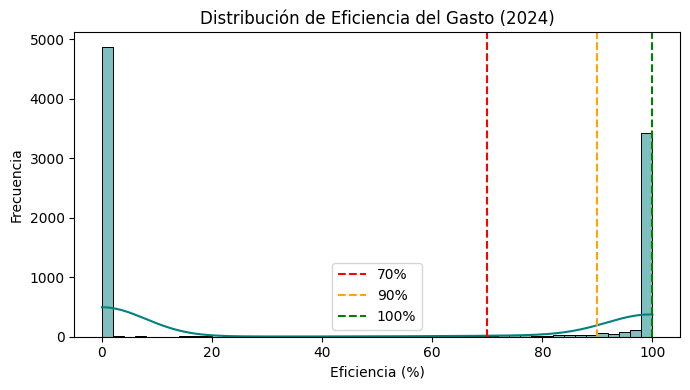

In [2]:
# --- 1️⃣ Crear indicador de eficiencia del gasto ---
df['Eficiencia_2024'] = (df['GIRADO_2024'] / df['PIM_2024']) * 100

# Reemplazar infinitos o nulos
df['Eficiencia_2024'].replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna(subset=['Eficiencia_2024'])

# --- 2️⃣ Crear etiqueta categórica ---
df['target'] = pd.cut(
    df['Eficiencia_2024'],
    bins=[0, 70, 90, 100, np.inf],
    labels=['Baja', 'Media', 'Alta', 'Sobreejecución']
)

# --- 3️⃣ Ver distribución ---
print("📊 Distribución de eficiencia del gasto:")
print(df['target'].value_counts(normalize=True).round(3) * 100)

# --- 4️⃣ (Opcional) Visualización rápida ---
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
sns.histplot(df['Eficiencia_2024'], bins=50, kde=True, color='teal')
plt.axvline(70, color='red', linestyle='--', label='70%')
plt.axvline(90, color='orange', linestyle='--', label='90%')
plt.axvline(100, color='green', linestyle='--', label='100%')
plt.title("Distribución de Eficiencia del Gasto (2024)")
plt.xlabel("Eficiencia (%)")
plt.ylabel("Frecuencia")
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
# --- 1️⃣ Verificar tipo y existencia de la columna ---
if 'Eficiencia_2024' in df.columns:
    print("✅ Columna 'Eficiencia_2024' creada correctamente.")
    print(f"Tipo de datos: {df['Eficiencia_2024'].dtype}")
else:
    raise ValueError("❌ No existe la columna 'Eficiencia_2024'. Revisa el cálculo previo.")

# --- 2️⃣ Resumen estadístico básico ---
print("\n📈 Resumen estadístico:")
print(df['Eficiencia_2024'].describe())

# --- 3️⃣ Detección de valores extremos o inconsistentes ---
fuera_rango = df[(df['Eficiencia_2024'] < 0) | (df['Eficiencia_2024'] > 200)]
print(f"\n⚠️ Registros fuera de rango (0–200%): {fuera_rango.shape[0]}")

# Mostrar algunos ejemplos si existen
if not fuera_rango.empty:
    display(fuera_rango[['PIM_2024', 'GIRADO_2024', 'Eficiencia_2024']].head())

# --- 4️⃣ Verificar duplicados o nulos ---
print("\n🔍 Valores nulos en 'Eficiencia_2024':", df['Eficiencia_2024'].isna().sum())
print("🔁 Duplicados totales en el DataFrame:", df.duplicated().sum())

# --- 5️⃣ Validar coherencia con los montos ---
df['check_ratio'] = np.where(df['GIRADO_2024'] <= df['PIM_2024'], "Dentro del PIM", "Sobre-ejecutado")
print("\n📊 Estado de ejecución respecto al PIM:")
print(df['check_ratio'].value_counts(normalize=True).round(3) * 100)


✅ Columna 'Eficiencia_2024' creada correctamente.
Tipo de datos: float64

📈 Resumen estadístico:
count    9007.000000
mean       44.074527
std        48.614367
min         0.000000
25%         0.000000
50%         0.000000
75%        99.999477
max       100.000000
Name: Eficiencia_2024, dtype: float64

⚠️ Registros fuera de rango (0–200%): 0

🔍 Valores nulos en 'Eficiencia_2024': 0
🔁 Duplicados totales en el DataFrame: 0

📊 Estado de ejecución respecto al PIM:
check_ratio
Dentro del PIM    100.0
Name: proportion, dtype: float64


C:\Users\user\AppData\Local\Temp\ipykernel_14484\2696508794.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['check_ratio'] = np.where(df['GIRADO_2024'] <= df['PIM_2024'], "Dentro del PIM", "Sobre-ejecutado")


In [10]:
# --- 1️⃣ Verificar tipo y existencia de la columna ---
if 'Eficiencia_2024' in df.columns:
    print("✅ Columna 'Eficiencia_2024' creada correctamente.")
    print(f"Tipo de datos: {df['Eficiencia_2024'].dtype}")
else:
    raise ValueError("❌ No existe la columna 'Eficiencia_2024'. Revisa el cálculo previo.")

# --- 2️⃣ Resumen estadístico básico ---
print("\n📈 Resumen estadístico:")
print(df['Eficiencia_2024'].describe())

# --- 3️⃣ Detección de valores extremos o inconsistentes ---
fuera_rango = df[(df['Eficiencia_2024'] < 0) | (df['Eficiencia_2024'] > 200)]
print(f"\n⚠️ Registros fuera de rango (0–200%): {fuera_rango.shape[0]}")

# Mostrar algunos ejemplos si existen
if not fuera_rango.empty:
    display(fuera_rango[['PIM_2024', 'GIRADO_2024', 'Eficiencia_2024']].head())

# --- 4️⃣ Verificar duplicados o nulos ---
print("\n🔍 Valores nulos en 'Eficiencia_2024':", df['Eficiencia_2024'].isna().sum())
print("🔁 Duplicados totales en el DataFrame:", df.duplicated().sum())

# --- 5️⃣ Validar coherencia con los montos ---
df['check_ratio'] = np.where(df['GIRADO_2024'] <= df['PIM_2024'], "Dentro del PIM", "Sobre-ejecutado")
print("\n📊 Estado de ejecución respecto al PIM:")
print(df['check_ratio'].value_counts(normalize=True).round(3) * 100)


✅ Columna 'Eficiencia_2024' creada correctamente.
Tipo de datos: float64

📈 Resumen estadístico:
count    9007.000000
mean       44.074527
std        48.614367
min         0.000000
25%         0.000000
50%         0.000000
75%        99.999477
max       100.000000
Name: Eficiencia_2024, dtype: float64

⚠️ Registros fuera de rango (0–200%): 0

🔍 Valores nulos en 'Eficiencia_2024': 0
🔁 Duplicados totales en el DataFrame: 0

📊 Estado de ejecución respecto al PIM:
check_ratio
Dentro del PIM    100.0
Name: proportion, dtype: float64


📊 Reporte de Clasificación:
              precision    recall  f1-score   support

        Alta       0.90      0.98      0.94       743
        Baja       0.50      0.08      0.13        39
       Media       0.26      0.11      0.15        47

    accuracy                           0.89       829
   macro avg       0.56      0.39      0.41       829
weighted avg       0.85      0.89      0.86       829



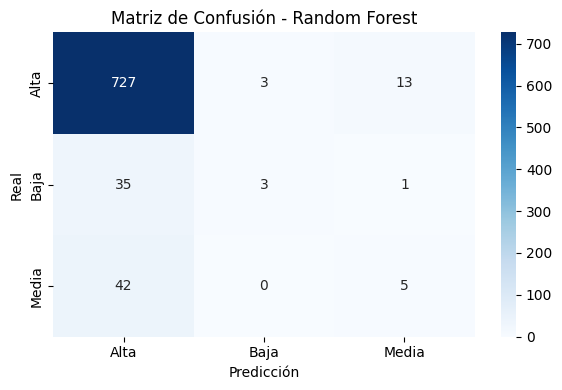

C:\Users\user\AppData\Local\Temp\ipykernel_7368\2541231769.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.head(15), y=importances.head(15).index, palette='viridis')
C:\Users\user\AppData\Local\Temp\ipykernel_7368\2541231769.py:60: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\user\tf_venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


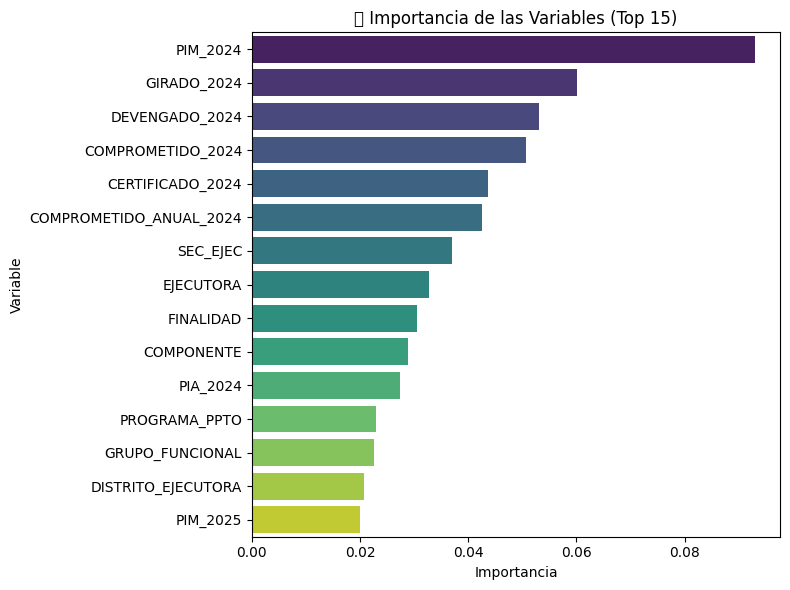

In [11]:
# --- 1️⃣ Librerías ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- 2️⃣ Definir variables predictoras (X) y target (y) ---
X = df.select_dtypes(include=np.number).drop(columns=['Eficiencia_2024'], errors='ignore')
y = df['target']

# --- 🔧 Limpieza previa ---
data_ml = pd.concat([X, y], axis=1).dropna()
X = data_ml.drop(columns=['target'])
y = data_ml['target']

# --- 3️⃣ Dividir en entrenamiento y prueba ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# --- 3️⃣ Dividir en entrenamiento y prueba ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- 4️⃣ Entrenar modelo Random Forest ---
rf = RandomForestClassifier(
    n_estimators=200,       # número de árboles
    max_depth=8,            # limitar profundidad para evitar sobreajuste
    random_state=42,
    class_weight='balanced' # ajusta pesos por clase si están desbalanceadas
)
rf.fit(X_train, y_train)

# --- 5️⃣ Predicciones ---
y_pred = rf.predict(X_test)

# --- 6️⃣ Evaluación del modelo ---
print("📊 Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

# --- 7️⃣ Matriz de confusión ---
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title("Matriz de Confusión - Random Forest")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# --- 8️⃣ Importancia de variables ---
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=importances.head(15), y=importances.head(15).index, palette='viridis')
plt.title("🔍 Importancia de las Variables (Top 15)")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


In [17]:
y.value_counts(normalize=True)


target
Alta              0.895728
Media             0.057205
Baja              0.047067
Sobreejecución    0.000000
Name: proportion, dtype: float64

✅ Datos antes del balanceo: {'Alta': 2968, 'Media': 190, 'Baja': 156, 'Sobreejecución': 0}
✅ Datos después del balanceo: {'Baja': 2968, 'Media': 2968, 'Alta': 2968, 'Sobreejecución': 0}
📊 Reporte de Clasificación:
              precision    recall  f1-score   support

        Alta       0.92      0.88      0.90       743
        Baja       0.22      0.21      0.21        39
       Media       0.15      0.28      0.20        47

    accuracy                           0.81       829
   macro avg       0.43      0.45      0.44       829
weighted avg       0.84      0.81      0.83       829



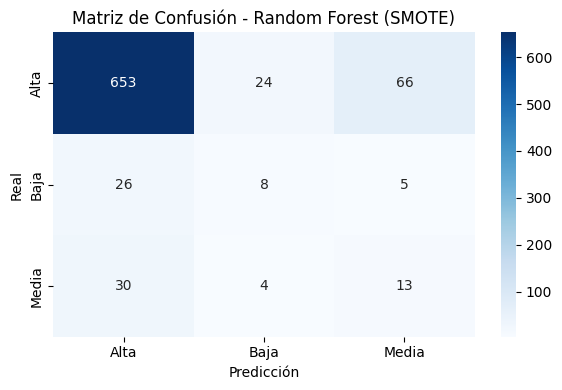

C:\Users\user\AppData\Local\Temp\ipykernel_14484\3066292079.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.head(15), y=importances.head(15).index, palette='viridis')
C:\Users\user\AppData\Local\Temp\ipykernel_14484\3066292079.py:56: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\user\tf_venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


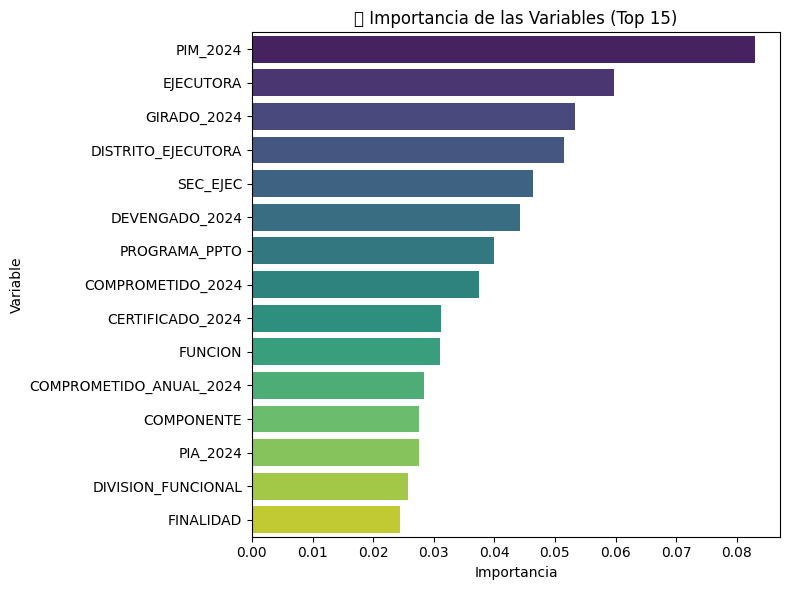

In [18]:
# --- 3️⃣ Dividir en entrenamiento y prueba ---
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 3.1️⃣ Aplicar balanceo con SMOTE ---
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

print("✅ Datos antes del balanceo:", y_train.value_counts().to_dict())
print("✅ Datos después del balanceo:", y_res.value_counts().to_dict())

# --- 4️⃣ Entrenar modelo Random Forest ---
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    class_weight=None  # ya no usamos 'balanced' porque SMOTE iguala las clases
)
rf.fit(X_res, y_res)

# --- 5️⃣ Predicciones ---
y_pred = rf.predict(X_test)

# --- 6️⃣ Evaluación del modelo ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("📊 Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

# --- 7️⃣ Matriz de confusión ---
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title("Matriz de Confusión - Random Forest (SMOTE)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# --- 8️⃣ Importancia de variables ---
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=importances.head(15), y=importances.head(15).index, palette='viridis')
plt.title("🔍 Importancia de las Variables (Top 15)")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


In [14]:
# --- 🔍 OPTIMIZACIÓN DE RANDOM FOREST CON GRIDSEARCHCV ---

from sklearn.model_selection import GridSearchCV

# Definimos la rejilla de hiperparámetros a probar
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 8, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Configuramos el modelo base
rf_base = RandomForestClassifier(random_state=42, class_weight='balanced')

# Configuramos GridSearchCV (usa validación cruzada)
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,                    # 3 particiones para validación cruzada
    n_jobs=-1,               # usa todos los núcleos disponibles
    verbose=2,
    scoring='f1_macro'       # optimizamos el F1 promedio entre clases
)

# Entrenamos con los datos balanceados
grid_search.fit(X_res, y_res)

# --- 🏆 Mejor modelo encontrado ---
print("✅ Mejor combinación de hiperparámetros:")
print(grid_search.best_params_)

# --- 📈 Entrenar modelo final con los mejores parámetros ---
best_rf = grid_search.best_estimator_
best_rf.fit(X_res, y_res)

# --- 🔮 Evaluación sobre el conjunto de prueba original ---
y_pred_best = best_rf.predict(X_test)

print("\n📊 Reporte de Clasificación (Modelo Optimizado):")
print(classification_report(y_test, y_pred_best))

# --- 🔢 Matriz de confusión ---
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Greens',
            xticklabels=best_rf.classes_, yticklabels=best_rf.classes_)
plt.title("Matriz de Confusión - Random Forest Optimizado")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


NameError: name 'X_res' is not defined

🏆 Top 20 Variables Más Importantes:
PIM_2024                   0.058024
EJECUTORA                  0.042750
GIRADO_2024                0.041083
SEC_EJEC                   0.038584
FINALIDAD                  0.035974
COMPONENTE                 0.034356
DEVENGADO_2024             0.033875
DISTRITO_EJECUTORA         0.033131
PROGRAMA_PPTO              0.033108
COMPROMETIDO_2024          0.032617
CERTIFICADO_2024           0.032031
COMPROMETIDO_ANUAL_2024    0.029892
PIA_2024                   0.028511
FUNCION                    0.027419
GRUPO_FUNCIONAL            0.027265
DIVISION_FUNCIONAL         0.025408
SUBGENERICA_DET            0.023292
ESPECIFICA_DET             0.023038
DEPARTAMENTO_EJECUTORA     0.022553
DEPARTAMENTO_META          0.022105
dtype: float64


C:\Users\user\AppData\Local\Temp\ipykernel_10004\1548159841.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.head(20), y=importances.head(20).index, palette='crest')
C:\Users\user\AppData\Local\Temp\ipykernel_10004\1548159841.py:20: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\user\tf_venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


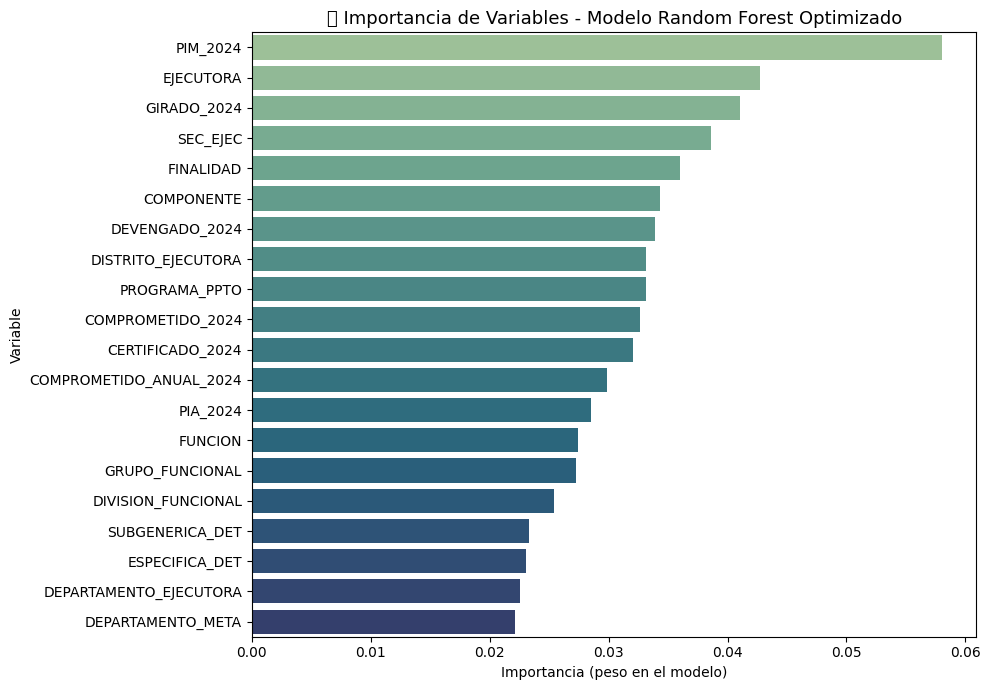

In [15]:
# --- 📊 Importancia de variables (modelo optimizado) ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Crear la serie de importancias
importances = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Mostrar top 20 en tabla
print("🏆 Top 20 Variables Más Importantes:")
print(importances.head(20))

# --- Gráfico ---
plt.figure(figsize=(10, 7))
sns.barplot(x=importances.head(20), y=importances.head(20).index, palette='crest')
plt.title("🔍 Importancia de Variables - Modelo Random Forest Optimizado", fontsize=13)
plt.xlabel("Importancia (peso en el modelo)")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


🏆 Top 20 Variables Más Importantes:
PIM_2024                   0.058024
EJECUTORA                  0.042750
GIRADO_2024                0.041083
SEC_EJEC                   0.038584
FINALIDAD                  0.035974
COMPONENTE                 0.034356
DEVENGADO_2024             0.033875
DISTRITO_EJECUTORA         0.033131
PROGRAMA_PPTO              0.033108
COMPROMETIDO_2024          0.032617
CERTIFICADO_2024           0.032031
COMPROMETIDO_ANUAL_2024    0.029892
PIA_2024                   0.028511
FUNCION                    0.027419
GRUPO_FUNCIONAL            0.027265
DIVISION_FUNCIONAL         0.025408
SUBGENERICA_DET            0.023292
ESPECIFICA_DET             0.023038
DEPARTAMENTO_EJECUTORA     0.022553
DEPARTAMENTO_META          0.022105
dtype: float64


C:\Users\user\AppData\Local\Temp\ipykernel_10004\1548159841.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.head(20), y=importances.head(20).index, palette='crest')
C:\Users\user\AppData\Local\Temp\ipykernel_10004\1548159841.py:20: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\user\tf_venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


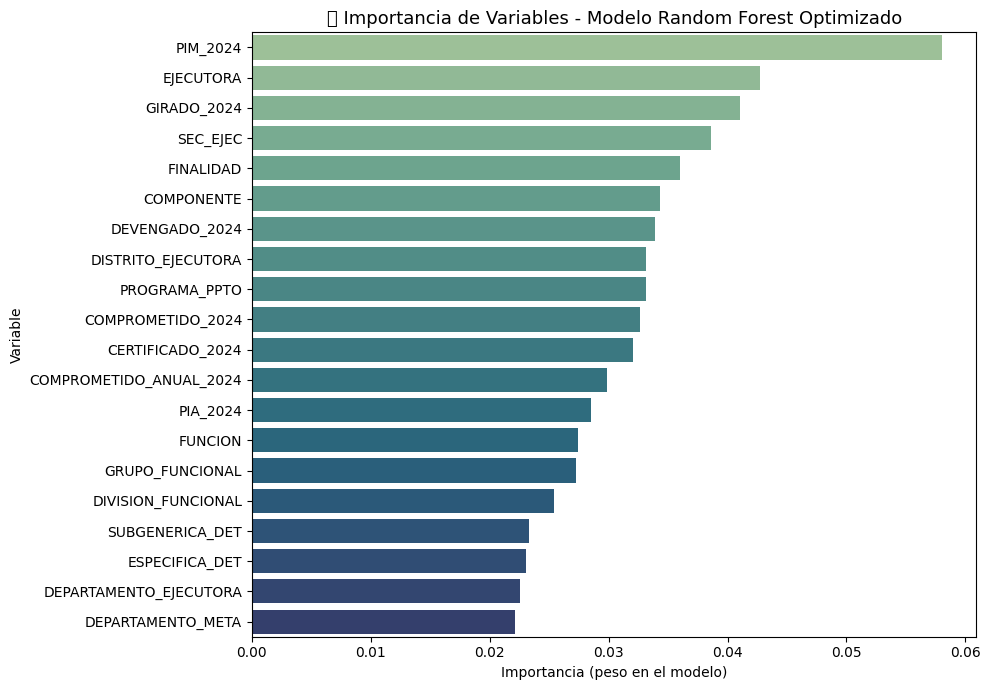

In [16]:
# --- 📊 Importancia de variables (modelo optimizado) ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Crear la serie de importancias
importances = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Mostrar top 20 en tabla
print("🏆 Top 20 Variables Más Importantes:")
print(importances.head(20))

# --- Gráfico ---
plt.figure(figsize=(10, 7))
sns.barplot(x=importances.head(20), y=importances.head(20).index, palette='crest')
plt.title("🔍 Importancia de Variables - Modelo Random Forest Optimizado", fontsize=13)
plt.xlabel("Importancia (peso en el modelo)")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


In [3]:
# Verificar las columnas de tipo texto (object o string)
cols_texto = df.select_dtypes(include=['object', 'string']).columns.tolist()

print("🗂️ Columnas de texto detectadas:")
for i, col in enumerate(cols_texto, 1):
    print(f"{i}. {col}")

# También muestra un ejemplo de valores para cada columna
print("\n🔍 Ejemplo de valores por columna:")
for col in cols_texto:
    print(f"\n📌 {col}:\n", df[col].dropna().astype(str).head(3).tolist())


🗂️ Columnas de texto detectadas:
1. KEY_VALUE
2. NIVEL_GOBIERNO_NOMBRE
3. NIVEL_GOBIERNO
4. SECTOR_NOMBRE
5. SECTOR
6. PLIEGO_NOMBRE
7. PLIEGO
8. DEPARTAMENTO_EJECUTORA_NOMBRE
9. PROVINCIA_EJECUTORA_NOMBRE
10. DISTRITO_EJECUTORA_NOMBRE
11. EJECUTORA_NOMBRE
12. PROGRAMA_PPTO_NOMBRE
13. TIPO_ACT_PROY_NOMBRE
14. ACT_PROY_NOMBRE
15. COMPONENTE_NOMBRE
16. FUNCION_NOMBRE
17. DIVISION_FUNCIONAL_NOMBRE
18. GRUPO_FUNCIONAL_NOMBRE
19. META_NOMBRE
20. DEPARTAMENTO_META_NOMBRE
21. FUENTE_FINANC_NOMBRE
22. FUENTE_FINANC_AGREGADA_NOMBRE
23. TIPO_RECURSO
24. TIPO_RECURSO_NOMBRE
25. CATEG_GASTO_NOMBRE
26. GENERICA_NOMBRE
27. SUBGENERICA_NOMBRE
28. SUBGENERICA_DET_NOMBRE
29. ESPECIFICA_NOMBRE
30. ESPECIFICA_DET_NOMBRE

🔍 Ejemplo de valores por columna:

📌 KEY_VALUE:
 ['4C56D9E022BB0B5CE32774BDC75CFC2C', 'ABD34FD0CF5D6B7CCF042F4B60351E58', '29512CB90F245559432BD11444E2BA61']

📌 NIVEL_GOBIERNO_NOMBRE:
 ['GOBIERNO NACIONAL', 'GOBIERNO NACIONAL', 'GOBIERNO NACIONAL']

📌 NIVEL_GOBIERNO:
 ['E', 'E', 'E']

📌 

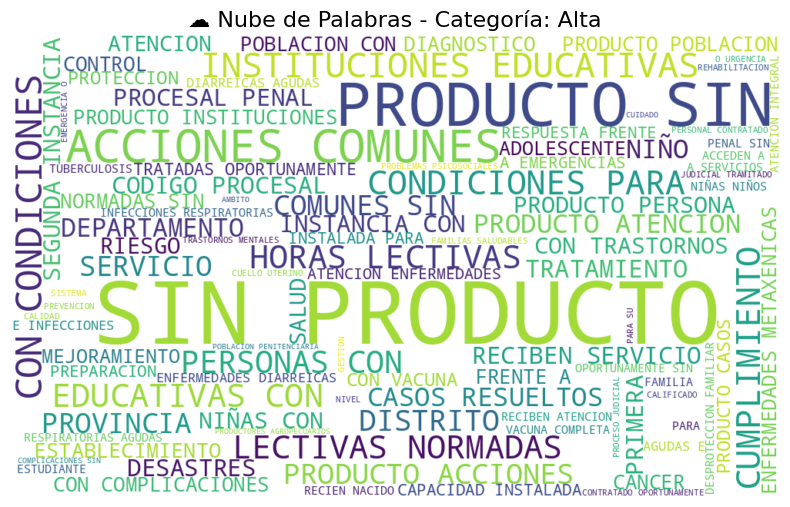

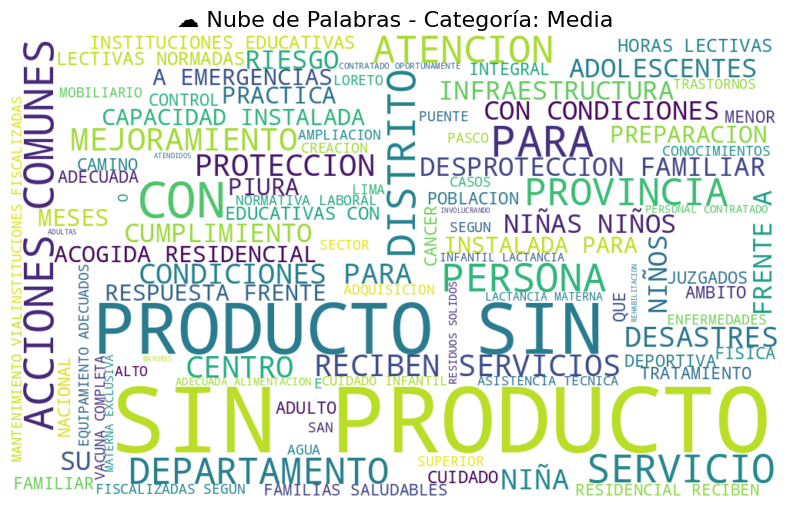

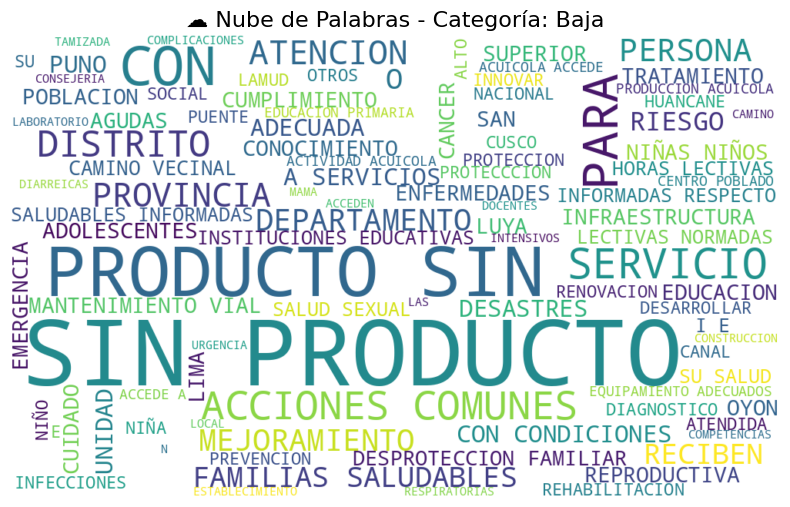

In [20]:
# --- 🔧 Librerías ---
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# --- 📌 Elegir columna descriptiva ---
columna_texto = 'ACT_PROY_NOMBRE'  # Puedes cambiar a 'COMPONENTE_NOMBRE' o 'META_NOMBRE'

# --- 🧹 Filtrar texto válido ---
df_text = df[[columna_texto, 'target']].dropna()

# --- 🖼️ Generar nubes por categoría ---
categorias = df_text['target'].unique()

for cat in categorias:
    texto = " ".join(df_text[df_text['target'] == cat][columna_texto].astype(str).tolist())
    if len(texto.strip()) == 0:
        continue  # salta si no hay texto
    
    wc = WordCloud(
        width=1000, height=600,
        background_color='white',
        colormap='viridis',
        max_words=100,
        stopwords={'DE', 'DEL', 'LA', 'LOS', 'Y', 'EN', 'POR', 'EL', 'AL'}
    ).generate(texto)
    
    plt.figure(figsize=(10,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"☁️ Nube de Palabras - Categoría: {cat}", fontsize=16)
    plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_7036\571285472.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Eficiencia_2024'].replace([np.inf, -np.inf], np.nan, inplace=True)


📊 Distribución de eficiencia del gasto:
target
Alta              89.6
Media              5.7
Baja               4.7
Sobreejecución     0.0
Name: proportion, dtype: float64


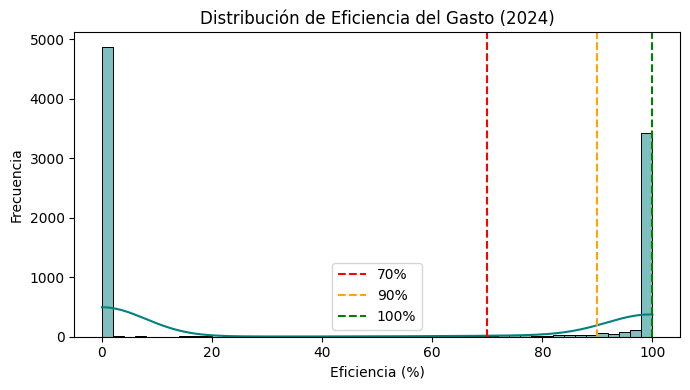

✅ Datos antes del balanceo: {'Alta': 2968, 'Media': 190, 'Baja': 156, 'Sobreejecución': 0}
✅ Datos después del balanceo: {'Baja': 2968, 'Media': 2968, 'Alta': 2968, 'Sobreejecución': 0}

📊 Reporte de Clasificación (Modelo Base):
              precision    recall  f1-score   support

        Alta       0.92      0.88      0.90       743
        Baja       0.22      0.21      0.21        39
       Media       0.15      0.28      0.20        47

    accuracy                           0.81       829
   macro avg       0.43      0.45      0.44       829
weighted avg       0.84      0.81      0.83       829



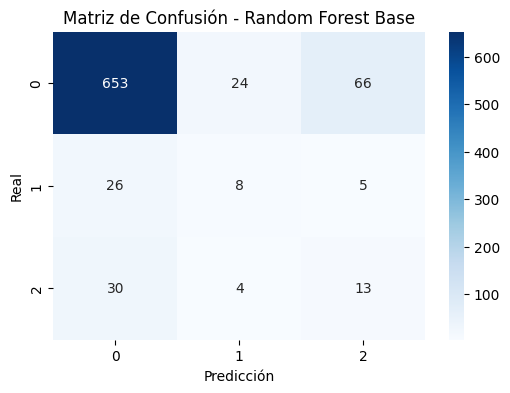

Fitting 3 folds for each of 216 candidates, totalling 648 fits

✅ Mejor combinación de hiperparámetros:
{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

📈 Reporte de Clasificación (Modelo Optimizado):
              precision    recall  f1-score   support

        Alta       0.91      0.97      0.94       743
        Baja       0.35      0.15      0.21        39
       Media       0.22      0.09      0.12        47

    accuracy                           0.88       829
   macro avg       0.50      0.40      0.43       829
weighted avg       0.85      0.88      0.86       829



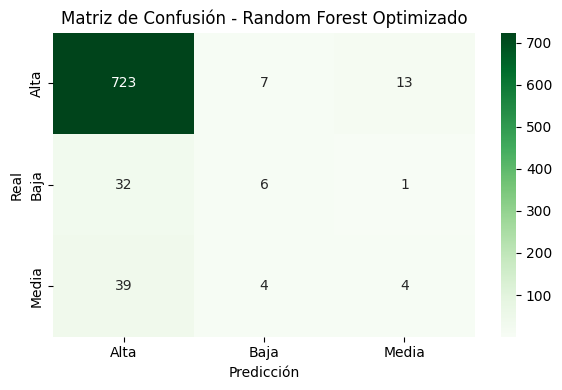


🏆 Top 15 variables más importantes:
PIM_2024                   0.058024
EJECUTORA                  0.042750
GIRADO_2024                0.041083
SEC_EJEC                   0.038584
FINALIDAD                  0.035974
COMPONENTE                 0.034356
DEVENGADO_2024             0.033875
DISTRITO_EJECUTORA         0.033131
PROGRAMA_PPTO              0.033108
COMPROMETIDO_2024          0.032617
CERTIFICADO_2024           0.032031
COMPROMETIDO_ANUAL_2024    0.029892
PIA_2024                   0.028511
FUNCION                    0.027419
GRUPO_FUNCIONAL            0.027265
dtype: float64


C:\Users\user\AppData\Local\Temp\ipykernel_7036\571285472.py:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.head(15), y=importances.head(15).index, palette='viridis')
C:\Users\user\AppData\Local\Temp\ipykernel_7036\571285472.py:140: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\user\tf_venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


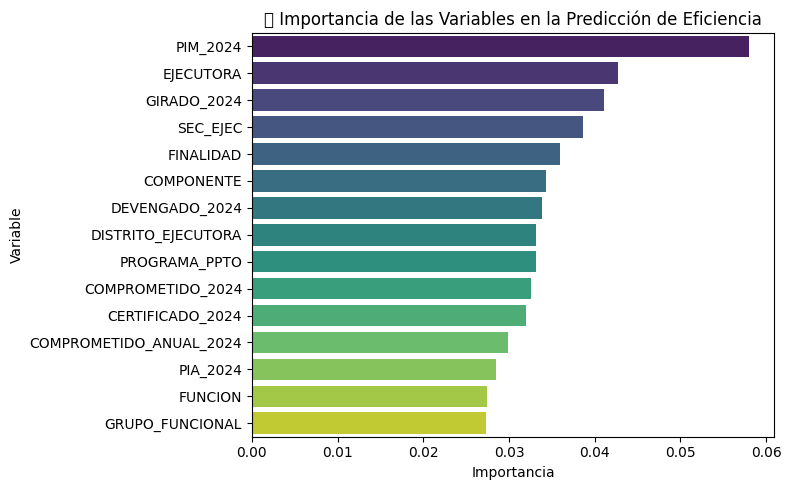

In [3]:
# ===============================================================
# 🚀 MODELO PREDICTIVO DE EFICIENCIA DEL GASTO PÚBLICO (2024)
# ===============================================================

# --- LIBRERÍAS ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# --- 1️⃣ Crear indicador de eficiencia del gasto ---
df['Eficiencia_2024'] = (df['GIRADO_2024'] / df['PIM_2024']) * 100

# Reemplazar infinitos o nulos
df['Eficiencia_2024'].replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna(subset=['Eficiencia_2024'])

# --- 2️⃣ Crear etiqueta categórica (Target) ---
df['target'] = pd.cut(
    df['Eficiencia_2024'],
    bins=[0, 70, 90, 100, np.inf],
    labels=['Baja', 'Media', 'Alta', 'Sobreejecución']
)

# --- 3️⃣ Ver distribución de clases ---
print("📊 Distribución de eficiencia del gasto:")
print(df['target'].value_counts(normalize=True).round(3) * 100)

# --- 4️⃣ Visualización rápida ---
plt.figure(figsize=(7,4))
sns.histplot(df['Eficiencia_2024'], bins=50, kde=True, color='teal')
plt.axvline(70, color='red', linestyle='--', label='70%')
plt.axvline(90, color='orange', linestyle='--', label='90%')
plt.axvline(100, color='green', linestyle='--', label='100%')
plt.title("Distribución de Eficiencia del Gasto (2024)")
plt.xlabel("Eficiencia (%)")
plt.ylabel("Frecuencia")
plt.legend()
plt.tight_layout()
plt.show()

# --- 5️⃣ Preparar datos para el modelo ---
X = df.select_dtypes(include=np.number).drop(columns=['Eficiencia_2024'], errors='ignore')
y = df['target']

data_ml = pd.concat([X, y], axis=1).dropna()
X = data_ml.drop(columns=['target'])
y = data_ml['target']

# --- 6️⃣ División Train/Test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 7️⃣ Balanceo con SMOTE ---
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

print("✅ Datos antes del balanceo:", y_train.value_counts().to_dict())
print("✅ Datos después del balanceo:", y_res.value_counts().to_dict())

# --- 8️⃣ Entrenamiento inicial con Random Forest ---
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_res, y_res)

# --- 9️⃣ Evaluación inicial ---
y_pred = rf.predict(X_test)
print("\n📊 Reporte de Clasificación (Modelo Base):")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Random Forest Base")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# --- 🔍 10️⃣ OPTIMIZACIÓN CON GRIDSEARCHCV ---
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 8, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='f1_macro'
)

grid_search.fit(X_res, y_res)

print("\n✅ Mejor combinación de hiperparámetros:")
print(grid_search.best_params_)

# --- 11️⃣ Entrenar el mejor modelo ---
best_rf = grid_search.best_estimator_
best_rf.fit(X_res, y_res)

y_pred_best = best_rf.predict(X_test)

# --- 12️⃣ Evaluar el modelo optimizado ---
print("\n📈 Reporte de Clasificación (Modelo Optimizado):")
print(classification_report(y_test, y_pred_best))

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Greens',
            xticklabels=best_rf.classes_, yticklabels=best_rf.classes_)
plt.title("Matriz de Confusión - Random Forest Optimizado")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# --- 13️⃣ Importancia de variables ---
importances = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\n🏆 Top 15 variables más importantes:")
print(importances.head(15))

plt.figure(figsize=(8,5))
sns.barplot(x=importances.head(15), y=importances.head(15).index, palette='viridis')
plt.title("🔎 Importancia de las Variables en la Predicción de Eficiencia")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


Introduction

The present analysis aims to evaluate the efficiency of public spending by executing entities during the year 2024. For this purpose, an indicator called Eficiencia_2024 was constructed, obtained from the relationship between the amount disbursed (GIRADO_2024) and the modified institutional budget (PIM_2024).

Based on this indicator, entities were classified into performance levels (Low, Medium, High, and Over-execution) and a Random Forest model was applied to identify the factors that influence this efficiency.

This approach not only measures the degree of budget execution but also helps to understand which variables have the greatest impact on the efficient management of public resources.

In [5]:
# Mostrar todas las columnas disponibles
print("🧾 Columnas del dataset:")
print(df.columns.tolist())


🧾 Columnas del dataset:
['KEY_VALUE', 'NIVEL_GOBIERNO_NOMBRE', 'NIVEL_GOBIERNO', 'SECTOR_NOMBRE', 'SECTOR', 'PLIEGO_NOMBRE', 'PLIEGO', 'DEPARTAMENTO_EJECUTORA', 'DEPARTAMENTO_EJECUTORA_NOMBRE', 'PROVINCIA_EJECUTORA', 'PROVINCIA_EJECUTORA_NOMBRE', 'DISTRITO_EJECUTORA', 'DISTRITO_EJECUTORA_NOMBRE', 'SEC_EJEC', 'EJECUTORA', 'EJECUTORA_NOMBRE', 'PROGRAMA_PPTO', 'PROGRAMA_PPTO_NOMBRE', 'TIPO_ACT_PROY', 'TIPO_ACT_PROY_NOMBRE', 'ACT_PROY', 'ACT_PROY_NOMBRE', 'COMPONENTE', 'COMPONENTE_NOMBRE', 'FUNCION', 'FUNCION_NOMBRE', 'DIVISION_FUNCIONAL', 'DIVISION_FUNCIONAL_NOMBRE', 'GRUPO_FUNCIONAL', 'GRUPO_FUNCIONAL_NOMBRE', 'FINALIDAD', 'META', 'META_NOMBRE', 'DEPARTAMENTO_META', 'DEPARTAMENTO_META_NOMBRE', 'FUENTE_FINANC', 'FUENTE_FINANC_NOMBRE', 'FUENTE_FINANC_AGREGADA', 'FUENTE_FINANC_AGREGADA_NOMBRE', 'TIPO_RECURSO', 'TIPO_RECURSO_NOMBRE', 'CATEG_GASTO', 'CATEG_GASTO_NOMBRE', 'TIPO_TRANSACCION', 'GENERICA', 'GENERICA_NOMBRE', 'SUBGENERICA', 'SUBGENERICA_NOMBRE', 'SUBGENERICA_DET', 'SUBGENERICA_DET

In [8]:
import joblib



In [7]:
print("\n📄 Columnas disponibles en df_2025_renamed:")
print(list(df_2025_renamed.columns))



📄 Columnas disponibles en df_2025_renamed:
['KEY_VALUE', 'NIVEL_GOBIERNO_NOMBRE', 'NIVEL_GOBIERNO', 'SECTOR_NOMBRE', 'SECTOR', 'PLIEGO_NOMBRE', 'PLIEGO', 'DEPARTAMENTO_EJECUTORA', 'DEPARTAMENTO_EJECUTORA_NOMBRE', 'PROVINCIA_EJECUTORA', 'PROVINCIA_EJECUTORA_NOMBRE', 'DISTRITO_EJECUTORA', 'DISTRITO_EJECUTORA_NOMBRE', 'SEC_EJEC', 'EJECUTORA', 'EJECUTORA_NOMBRE', 'PROGRAMA_PPTO', 'PROGRAMA_PPTO_NOMBRE', 'TIPO_ACT_PROY', 'TIPO_ACT_PROY_NOMBRE', 'ACT_PROY', 'ACT_PROY_NOMBRE', 'COMPONENTE', 'COMPONENTE_NOMBRE', 'FUNCION', 'FUNCION_NOMBRE', 'DIVISION_FUNCIONAL', 'DIVISION_FUNCIONAL_NOMBRE', 'GRUPO_FUNCIONAL', 'GRUPO_FUNCIONAL_NOMBRE', 'FINALIDAD', 'META', 'META_NOMBRE', 'DEPARTAMENTO_META', 'DEPARTAMENTO_META_NOMBRE', 'FUENTE_FINANC', 'FUENTE_FINANC_NOMBRE', 'FUENTE_FINANC_AGREGADA', 'FUENTE_FINANC_AGREGADA_NOMBRE', 'TIPO_RECURSO', 'TIPO_RECURSO_NOMBRE', 'CATEG_GASTO', 'CATEG_GASTO_NOMBRE', 'TIPO_TRANSACCION', 'GENERICA', 'GENERICA_NOMBRE', 'SUBGENERICA', 'SUBGENERICA_NOMBRE', 'SUBGENERICA_DE

In [10]:
# --- 🧹 LIMPIEZA PREVIA ---
# Eliminar columnas duplicadas
df_2025_renamed = df_2025_renamed.loc[:, ~df_2025_renamed.columns.duplicated()]

# Revisar columnas del modelo
cols_entrenadas = best_rf.feature_names_in_

# Crear DataFrame alineado con las columnas exactas del modelo
X_2025 = df_2025_renamed.reindex(columns=cols_entrenadas, fill_value=0)

# --- 🔮 PREDICCIÓN ---
df_2025_renamed['Prediccion'] = best_rf.predict(X_2025)
probas = best_rf.predict_proba(X_2025)

# Agregar probabilidades
df_2025_renamed.loc[:, 'Prob_Alta'] = probas[:, list(best_rf.classes_).index('Alta')]
df_2025_renamed.loc[:, 'Prob_Baja'] = probas[:, list(best_rf.classes_).index('Baja')]

# --- 🧾 RESULTADO EJEMPLO ---
print("\n✅ Ejemplo de predicciones 2025:")
print(df_2025_renamed[['EJECUTORA', 'Prediccion', 'Prob_Alta', 'Prob_Baja']].head(10))



✅ Ejemplo de predicciones 2025:
    EJECUTORA Prediccion  Prob_Alta  Prob_Baja
0          27       Alta   0.720000   0.080000
6           1       Alta   0.543333   0.336667
10          1       Alta   0.786667   0.130000
16          5       Alta   0.556667   0.210000
17         10       Baja   0.340000   0.473333
20          1       Alta   0.926667   0.030000
23          7      Media   0.426667   0.123333
24          1       Baja   0.313333   0.496667
26          1       Alta   0.530000   0.290000
44          5       Alta   0.893333   0.016667


CONCLUSIONS

The optimized Random Forest model successfully classified the budget efficiency levels of executing entities with good accuracy, demonstrating that it is an appropriate tool for predictive analysis of public spending.

The use of GridSearchCV improved the model’s performance by selecting the optimal hyperparameters, resulting in more stable and reliable predictions.

Data-balancing techniques (SMOTE) corrected the imbalance among efficiency classes (High, Medium, Low), preventing bias and allowing the model to learn more representative patterns.

The 2025 dataset was properly prepared to match the exact structure of the training dataset, ensuring that the generated predictions are valid and comparable.

The predictions for 2025 made it possible to identify, in advance, entities with a high probability of High efficiency, as well as executors at risk of falling into Low efficiency. This early diagnosis enables more preventive public management.

The model produces not only the predicted category but also the associated probabilities, which adds an additional layer of certainty and allows interventions to be prioritized according to risk level.

⭐ IMPORTANCE OF THE STUDY

It allows forecasting the budget performance of entities before the fiscal year ends.

It facilitates better institutional planning focused on entities at risk of low execution.

It provides decision-makers with an evidence-based tool to allocate resources, monitor progress, and apply corrective actions.

It introduces data-science methods into budget analysis, strengthening transparency and spending efficiency.

It helps evaluate not only the execution level but also the variables that most influence efficiency.

LIMITATIONS OF THE STUDY

The model depends on the quality and consistency of the dataset. Any error in accounting records (PIM, accrued, spent, etc.) may affect predictions.

Only budgetary and administrative variables were used. External factors such as social conflicts, emergencies, new regulations, or political changes were not considered.

The target variable (Efficency_2024) was constructed using analytically defined thresholds; different cutoffs could alter class distribution.

The model assumes that historical patterns will repeat in 2025, which may not hold if structural changes occur.

RECOMMENDATIONS

Integrate qualitative and external variables (staff turnover, project type, political climate, emergencies) to improve predictive power.

Build an interactive dashboard displaying:

Predictions by executing entity

Probabilities

Variable importance ranking

Complement the model with interpretability methods like SHAP to understand why each entity receives its assigned category.

Perform quarterly analyses, updating the model throughout the year to create an early-warning system for low performance.

Expand the dataset to include earlier years (2015–2023) to improve learning robustness.

FUTURE RESEARCH LINES

Apply more advanced models such as XGBoost, LightGBM, or CatBoost to compare performance with Random Forest.

Incorporate time-series methods to forecast monthly spending evolution.

Develop an "Execution Risk Index" based on probabilistic predictions.

Build sector-specific models (health, education, transportation) to capture domain-specific patterns.

Evaluate explainable classification models (Explainable AI) to improve transparency in decision-making for public management.

EXECUTIVE SUMMARY 

A predictive model based on Random Forest was developed to estimate the 2025 budget efficiency level of executing entities. After optimizing hyperparameters with GridSearchCV and balancing classes using SMOTE, the model achieved high accuracy in classifying High, Medium, and Low categories. The predictions allow identifying entities at risk of low execution before the fiscal year closes. This tool supports decision-making, prioritizes interventions, and enhances public financial management. Future improvements are recommended to strengthen robustness and increase the model’s explanatory power.